## Deep Learning Project 1 

Comparing digits

In [43]:
import torch
import math
import dlc_practical_prologue as prologue
from torch import optim
from torch import Tensor
from torch import nn
from torch.nn import functional as F

In [44]:
# Generate the train and test sets.
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

In [84]:
# Model Definition 

class Net(nn.Module):
    def __init__(self, nb_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        prt = False
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        if prt:
            print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        if prt:
            print(x.shape)
        x = F.relu(self.fc1(x.view(-1, 256)))
        if prt:
            print(x.shape)
        x = self.fc2(x)
        if prt:
            print(x.shape)
        return x


class Comparisson_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)
    
    def cnn(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x
    
    def forward(self, x):
        s = x.shape
        print(s)
        input_1 = x[:,0,:,:].reshape([s[0],1,s[2],s[3]])
        input_2 = x[:,1,:,:].reshape([s[0],1,s[2],s[3]])
        print(input_1.shape, input_2.shape)
        output_1 = self.cnn(input_1)
        output_2 = self.cnn(input_2)
        print(output_1, output_2)
        
        return 1 if  output_1 > output_2 else 0 
        
        

torch.Size([1000, 2, 14, 14])


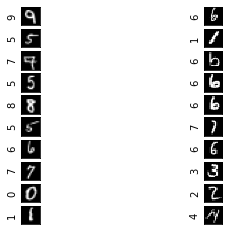

In [76]:
import matplotlib.pyplot as plt

print(train_input.shape)

fig ,axes = plt.subplots(10, 2)
for i in range(10):
    first = train_input[i][0,:,:]
    second = train_input[i][1,:,:]
    first_label = train_classes[i][0]
    second_label = train_classes[i][1]
    axes[i,0].imshow(first, cmap='gray')
    axes[i,0].set_ylabel(str(first_label.item()))
    axes[i,1].imshow(second, cmap='gray', interpolation='none')
    axes[i,1].set_ylabel(str(second_label.item()))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    fig

In [53]:
def train_model(model, train_input, train_target, mini_batch_size, nb_epochs = 100):
    criterion = nn.CrossEntropyLoss()
    eta = 1e-3
    for e in range(nb_epochs):
        acc_loss = 0

        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            acc_loss = acc_loss + loss.item()
 
            model.zero_grad()
            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    p -= eta * p.grad

        print(e, acc_loss)
        
def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

In [54]:
model = Net(200)

train_input_first = train_input[:,0,:,:].reshape([1000,1,14,14])
#train_classes_first = prologue.convert_to_one_hot_labels(train_input_first, train_classes[:,0])
train_model(model, train_input_first, train_classes[:,0], mini_batch_size=200, nb_epochs=100)

0 83.07379150390625
1 17.225753664970398
2 8.087629675865173
3 6.508502125740051
4 5.5445802211761475
5 4.839455306529999
6 4.27476179599762
7 3.8158993124961853
8 3.4500547647476196
9 3.1508256793022156
10 2.9060018062591553
11 2.691473662853241
12 2.5030227601528168
13 2.3426622450351715
14 2.201094329357147
15 2.076381593942642
16 1.9676635265350342
17 1.8706440031528473
18 1.7818549275398254
19 1.7017315328121185
20 1.6288729310035706
21 1.5603239834308624
22 1.4952377080917358
23 1.4351552575826645
24 1.3793738931417465
25 1.3270999938249588
26 1.278738483786583
27 1.2329051792621613
28 1.1893957555294037
29 1.1484296023845673
30 1.1096322536468506
31 1.0719872564077377
32 1.0367992669343948
33 1.0027882307767868
34 0.9717517048120499
35 0.9411021173000336
36 0.912038266658783
37 0.8849972039461136
38 0.8582970798015594
39 0.8330053836107254
40 0.8090366125106812
41 0.7865533381700516
42 0.7648034617304802
43 0.7439449578523636
44 0.7241906449198723
45 0.705128476023674
46 0.68694

In [55]:
test_input_first = test_input[:,0,:,:].reshape([1000,1,14,14])
test_classes_first = prologue.convert_to_one_hot_labels(test_input_first, test_classes[:,0])
nb_test_errors = compute_nb_errors(model, test_input_first, test_classes_first, mini_batch_size=200)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input_first.size(0),
                                                      nb_test_errors, test_input_first.size(0)))

test error Net 9.60% 96/1000


In [85]:
model2 = Comparisson_Net()


train_model(model2, train_input, train_target, mini_batch_size=200, nb_epochs=100)

torch.Size([200, 2, 14, 14])
torch.Size([200, 1, 14, 14]) torch.Size([200, 1, 14, 14])
tensor([[  6.7573,  -0.6668,   2.4406,  ...,   8.1474,  -4.0051, -17.9995],
        [ 10.2256,  -3.6260,   5.5699,  ...,   5.6834,  -8.7456,  -7.8770],
        [  5.4390,  -1.1102,   4.1383,  ...,   9.7175, -10.0729, -14.7232],
        ...,
        [  3.0957,  -3.6641,  -0.3118,  ...,   7.7384,  -6.7733, -11.7178],
        [  5.9055,  -2.6778,  -0.2602,  ...,   9.5142,  -3.2308, -12.2267],
        [  7.2614,   0.7065,   2.8962,  ...,   9.3985,  -7.9075, -15.1172]],
       grad_fn=<AddmmBackward>) tensor([[  5.6967,  -0.5139,   4.8891,  ...,   7.0900,  -6.6469,  -8.7954],
        [  3.1533,  -6.4154,   1.8406,  ...,  11.7050,  -6.8144,  -9.8480],
        [  5.5618,   4.8932,   1.0612,  ...,   3.2230,  -5.5525, -11.5279],
        ...,
        [  2.9802,  -3.5464,   1.2761,  ...,   4.2921,  -4.0978,  -8.9410],
        [  5.4074,   4.6492,   0.3372,  ...,   9.6221,  -9.3929, -14.5132],
        [  4.3528,

RuntimeError: bool value of Tensor with more than one value is ambiguous